This project generates animations of pytorch optimizers solving toy problems.


[Some nice animations](http://www.denizyuret.com/2015/03/alec-radfords-animations-for.html) were posted a few years ago by Alex Radford but didn't include Adam or landscapes with noise.  [Louis Tiao](http://louistiao.me/notes/visualizing-and-animating-optimization-algorithms-with-matplotlib/) blogged about how to make the visulisations. The [pytorch unit tests](https://github.com/pytorch/pytorch/blob/master/test/test_optim.py) show how to run the optimizers on a test function. I pulled these together and shared the result at https://github.com/wassname/visualizing_torch_optim.

References:

- functions:
    - [wikipedia test functions for opt](https://en.wikipedia.org/wiki/Test_functions_for_optimization)
    - [ssurjano a list of function and thier minima](https://www.sfu.ca/~ssurjano/optimization.html) 

- online symbolic algebra https://cocalc.com/settings?session=default

TODO:
- [x] faster saving, to a format that can be converted well
- [x] quality saving
- [x] lr scheudle
- [ ] add noise
- [ ] fix float errors on complex functions


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
from torch.autograd import Variable

In [3]:
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from collections import defaultdict
from itertools import zip_longest
from functools import partial

In [4]:
import datetime
ts = datetime.datetime.utcnow().strftime('%Y%m%d_%H-%M-%S')

# Helpers to create optimization paths

In [5]:
class Cycle(object):
    """
    Ref: https://arxiv.org/pdf/1506.01186v3.pdf
    """

    def __init__(self, lr0, lr1):
        self.lr0 = lr0
        self.lr1 = lr1

    def __call__(self, steps, epoch=1):
        x = itr - (2*cycle - 1)*
        cycle = math.floor(1 + epoch / (2 * stepsize))
        x = math.abs(epoch / stepsize - 2 * cycle + 1)
        lr = self.lr0 + (maxLR - self.lr0) * math.max(0, (1 - x))
        return lr

SyntaxError: invalid syntax (<ipython-input-5-2fa0739a3850>, line 11)

In [21]:
from torch import optim
from torch.optim import lr_scheduler


In [60]:
# from https://github.com/thomasjpfan/pytorch/blob/401ec389db2c9d2978917a6e4d1101b20340d7e7/torch/optim/lr_scheduler.py
# not merged into pytorch yet https://github.com/pytorch/pytorch/pull/2016
from torch.optim import Optimizer
class CyclicLR(object):
    """Sets the learning rate of each parameter group according to
    cyclical learning rate policy (CLR). The policy cycles the learning
    rate between two boundaries with a constant frequency, as detailed in
    the paper `Cyclical Learning Rates for Training Neural Networks`_.
    The distance between the two boundaries can be scaled on a per-iteration
    or per-cycle basis.
    Cyclical learning rate policy changes the learning rate after every batch.
    `batch_step` should be called after a batch has been used for training.
    To resume training, save `last_batch_iteration` and use it to instantiate `CycleLR`.
    This class has three built-in policies, as put forth in the paper:
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each
        cycle iteration.
    This implementation was adapted from the github repo: `bckenstler/CLR`_
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        base_lr (float or list): Initial learning rate which is the
            lower boundary in the cycle for eachparam groups.
            Default: 0.001
        max_lr (float or list): Upper boundaries in the cycle for
            each parameter group. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore
            max_lr may not actually be reached depending on
            scaling function. Default: 0.006
        step_size (int): Number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch. Default: 2000
        mode (str): One of {triangular, triangular2, exp_range}.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
            Default: 'triangular'
        gamma (float): Constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
            Default: 1.0
        scale_fn (function): Custom scaling policy defined by a single
            argument lambda function, where
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored
            Default: None
        scale_mode (str): {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on
            cycle number or cycle iterations (training
            iterations since start of cycle).
            Default: 'cycle'
        last_batch_iteration (int): The index of the last batch. Default: -1
    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> scheduler = torch.optim.CyclicLR(optimizer)
        >>> data_loader = torch.utils.data.DataLoader(...)
        >>> for epoch in range(10):
        >>>     for batch in data_loader:
        >>>         scheduler.batch_step()
        >>>         train_batch(...)
    .. _Cyclical Learning Rates for Training Neural Networks: https://arxiv.org/abs/1506.01186
    .. _bckenstler/CLR: https://github.com/bckenstler/CLR
    """

    def __init__(self, optimizer, base_lr=1e-3, max_lr=6e-3,
                 step_size=2000, mode='triangular', gamma=1.,
                 scale_fn=None, scale_mode='cycle', last_batch_iteration=-1):

        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer

        if isinstance(base_lr, list) or isinstance(base_lr, tuple):
            if len(base_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} base_lr, got {}".format(
                    len(optimizer.param_groups), len(base_lr)))
            self.base_lrs = list(base_lr)
        else:
            self.base_lrs = [base_lr] * len(optimizer.param_groups)

        if isinstance(max_lr, list) or isinstance(max_lr, tuple):
            if len(max_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} max_lr, got {}".format(
                    len(optimizer.param_groups), len(max_lr)))
            self.max_lrs = list(max_lr)
        else:
            self.max_lrs = [max_lr] * len(optimizer.param_groups)

        self.step_size = step_size

        if mode not in ['triangular', 'triangular2', 'exp_range'] \
                and scale_fn is None:
            raise ValueError('mode is invalid and scale_fn is None')

        self.mode = mode
        self.gamma = gamma

        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = self._triangular_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = self._triangular2_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = self._exp_range_scale_fn
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode

        self.batch_step(last_batch_iteration + 1)
        self.last_batch_iteration = last_batch_iteration

    def batch_step(self, batch_iteration=None):
        if batch_iteration is None:
            batch_iteration = self.last_batch_iteration + 1
        self.last_batch_iteration = batch_iteration
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

    def _triangular_scale_fn(self, x):
        return 1.

    def _triangular2_scale_fn(self, x):
        return 1 / (2. ** (x - 1))

    def _exp_range_scale_fn(self, x):
        return self.gamma**(x)

    def get_lr(self):
        step_size = float(self.step_size)
        cycle = np.floor(1 + self.last_batch_iteration / (2 * step_size))
        x = np.abs(self.last_batch_iteration / step_size - 2 * cycle + 1)

        lrs = []
        param_lrs = zip(self.optimizer.param_groups, self.base_lrs, self.max_lrs)
        for param_group, base_lr, max_lr in param_lrs:
            base_height = (max_lr - base_lr) * np.maximum(0, (1 - x))
            if self.scale_mode == 'cycle':
                lr = base_lr + base_height * self.scale_fn(cycle)
            else:
                lr = base_lr + base_height * self.scale_fn(self.last_batch_iteration)
            lrs.append(lr)
        return lrs

In [61]:
"""modified from https://github.com/pytorch/pytorch/blob/master/test/test_optim.py"""

def test_f(f, df, constructor, steps=150, x0=[-4,-1], solution=[-2,0], scheduler=None, exact=True):
    """
    params:
    scheduler: e.g. scheduler = torch.optim.CyclicLR(optimizer)
    """
    state = {}

    # start
    params = Variable(torch.Tensor(x0), requires_grad=True)
    optimizer = constructor([params])
    if scheduler:
        _scheduler = scheduler(optimizer)

    solution = torch.Tensor(solution)
    initial_dist = params.data.dist(solution)

    def eval():
        optimizer.zero_grad()
        loss = f(params)
        loss.backward()
        
        if exact:
            # loss.backward() will give **slightly** different
            # gradients, than drosenbtock, because of a different ordering
            # of floating point operations. In most cases it doesn't matter,
            # but some optimizers are so sensitive that they can temporarily
            # diverge up to 1e-4, just to converge again. This makes the
            # comparison more stable.
            params.grad.data.copy_(df(params.data))
        return loss

    data=[]
    dist=[]
    lrs=[]
    for i in range(steps):
        
        optimizer.step(eval)
        if scheduler:
            _scheduler.batch_step()
        
        # record
        dist.append(params.data.dist(solution)) # loss
        data.append(params.data.numpy().copy())
        lrs.append(optimizer.param_groups[0]['lr'])
    return np.array(data), np.array(dist), lrs

# Functions

Tip when making new problems:

- get them from [here](https://www.sfu.ca/~ssurjano/optimization.html)

- and calculate the derivative using sagemath. Go to https://cocalc.com/ and execute code like this:
```py
x = var('x')
y = var('y')
r=(1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2
print 'dx =',simplify(derivative(r,x))
print 'dy =',simplify(derivative(r,y))
# output:
# dx = 2*(x*y^3 - x + 2.625)*(y^3 - 1) + 2*(x*y^2 - x + 2.25)*(y^2 - 1) + 2*(x*y - x + 1.5)*(y - 1)
# dy = 6*(x*y^3 - x + 2.625)*x*y^2 + 4*(x*y^2 - x + 2.25)*x*y + 2*(x*y - x + 1.5)*x
```

TODO:

- [ ] add noise

In [62]:
azim=-95

In [63]:
def to_tensor(x):
    # TODO: I'm sure there's a proper way to do this
    if isinstance(x, np.ndarray):
        return torch.FloatTensor(x.astype(np.float32))
    if isinstance(x, list):
        return torch.FloatTensor(x)
    elif isinstance(x, (float, int, numpy.generic)):
        return torch.FloatTensor([float(x)])
    else:
        return x
    
# def from_tensor(x):
#     x = getattr(x,'data',x)
#     if hasattr(x, 'numpy'):
#         x = x.numpy()
#     return x
# to_tensor(1.0)
# to_tensor(1)
# to_tensor(np.array([1.0]))
# to_tensor([1.0])
# to_tensor(torch.rand((4,4)))
# to_tensor(Variable(torch.rand((4,4))))

In [64]:
class Problem(object):
    def __init__(self, f, df, minima, x0, bounds=[[-5,5],[-5,5]], lr=1e-3, steps=3000):
        """
        Problem setup
        
        Params:
        - f: function [x1,x2] => z
        - df: derivative function ([x1,x2]=>[dx1,dx2])
        - minima: where the function has a minima
        - self: bounds
        
        - x0: suggested start
        - lr: suggested learning rate
        - steps: suggested steps
        """
        self.f = f
        self.df = df
        self.x0 = x0
        self.bounds = bounds
        self.minima = minima
        self.lr = lr
        self.steps = steps
        
        self.xmin = bounds[0][0]
        self.xmax = bounds[0][1]
        self.ymin = bounds[1][0]
        self.ymax = bounds[1][1]

In [65]:
"""A valley"""
def madsen(tensor):
    """Madsen function (1981)."""
    x1, x2 = tensor
    x1 = to_tensor(x1)
    x2 = to_tensor(x2)

    r = x1**2 + x2**2 + x1 * x2 +\
            torch.sin(x1) +\
            torch.cos(x2) #+ np.abs(noise(x1,x2))
    return r
        
        
def dmadsen(tensor):
    x1, x2 = tensor
    x1 = to_tensor(x1)
    x2 = to_tensor(x2)
    dx1=2. * x1 + x2 + np.cos(x1)
    dx2 = 2. * x2 + x1 -np.sin(x2)
    return  torch.stack([dx1, dx2],1)[0]
 

madsen_problem= Problem(
    f=madsen,
    df=dmadsen,
    minima=np.array([-0.39999999999999591, 0.20000000000000462]),
    x0=[-3,-4],
    steps=3000,
    lr=1e-4
)
problem=madsen_problem

In [66]:
def schaffern4(tensor):
    """https://www.sfu.ca/~ssurjano/schaffer4.html"""
    x1, x2 = tensor
    x1 = to_tensor(x1)
    x2 = to_tensor(x2)

    r = 0.5 + (cos(sin(abs(x1**2-x2**2))) - 0.5)/(1+0.001*(x1**2+x2**2))**2
    return r*100


def dschaffern4(tensor):
    x1, x2 = tensor
    x1 = to_tensor(x1)
    x2 = to_tensor(x2)
    dx1 = -2*(x1**2 - x2**2)*x1*cos(abs(-x1**2 + x2**2))*sin(sin(abs(-x1**2 + x2**2)))/((0.001*x1**2 + 0.001*x2**2 + 1.0)**2*abs(-x1**2 + x2**2)) - 0.004*x1*(cos(sin(abs(-x1**2 + x2**2))) - 0.5)/(0.001*x1**2 + 0.001*x2**2 + 1.0)**3
    dx2 = 2*(x1**2 - x2**2)*x2*cos(abs(-x1**2 + x2**2))*sin(sin(abs(-x1**2 + x2**2)))/((0.001*x1**2 + 0.001*x2**2 + 1.0)**2*abs(-x1**2 + x2**2)) - 0.004*x2*(cos(sin(abs(-x1**2 + x2**2))) - 0.5)/(0.001*x1**2 + 0.001*x2**2 + 1.0)**3
    return torch.stack([dx1, dx2], 1)[0]


schaffern4_problem = Problem(
    f=schaffern4,
    df=dschaffern4,
#     minima=np.array([0, 1.25313]),
    minima=np.array([100,100]),
    bounds=[[-100, 100], [-100, 100]],
    x0=[10, 5],
    steps=3000,
    lr=1e-1
)
problem = schaffern4_problem

In [67]:
"""Banana shaped"""
def rosenbrock(tensor):
    x, y = tensor
    x = to_tensor(x)
    y = to_tensor(y)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2


def drosenbrock(tensor):
    x, y = tensor
    x = to_tensor(x)
    y = to_tensor(y)
    dx = 400 * (x**2 -y) + 2 * x - 2 
    dy = -200 * x**2 + 200 * y
    return torch.stack([dx,dy],1)[0]


rosenbrock_problem= Problem(
    f=rosenbrock,
    df=drosenbrock,
    minima=np.array([1,1]),
    x0=[-3,-4],
    steps=3000,
    lr=1e-4
)
problem=rosenbrock_problem


In [68]:
from torch import sin, cos, sqrt, abs, log
def eggholder(tensor):
    """https://www.sfu.ca/~ssurjano/camel6.html"""
    x1, x2 = tensor
    x1 = to_tensor(x1)
    x2 = to_tensor(x2)

    r = - (x2+47)*sin(sqrt(abs(x2+x1/2+47))) - x1*sin(sqrt(abs(x1-(x2+47))))
    return r


def deggholder(tensor):
    x1, x2 = tensor
    x1 = to_tensor(x1)
    x2 = to_tensor(x2)
    dx1 = -1/8*(x1 + 2*x2 + 94)*(x2 + 47)*cos(sqrt(abs(1/2*x1 + x2 + 47)))/abs(1/2*x1 + x2 + 47)**(3/2) - 1/2*(x1 - x2 - 47)*x1*cos(sqrt(abs(-x1 + x2 + 47)))/abs(-x1 + x2 + 47)**(3/2) - sin(sqrt(abs(-x1 + x2 + 47)))
    dx2 = -1/4*(x1 + 2*x2 + 94)*(x2 + 47)*cos(sqrt(abs(1/2*x1 + x2 + 47)))/abs(1/2*x1 + x2 + 47)**(3/2) + 1/2*(x1 - x2 - 47)*x1*cos(sqrt(abs(-x1 + x2 + 47)))/abs(-x1 + x2 + 47)**(3/2) - sin(sqrt(abs(1/2*x1 + x2 + 47))) 
    return torch.stack([dx1, dx2], 1)[0]


eggholder_problem = Problem(
    f=eggholder,
    df=deggholder,
    minima=np.array([-512, -404.2319]),
    bounds=[[-512, 512], [-512, 512]],
    x0=[100,300],
    steps=3000,
    lr=1e-4
)
problem = eggholder_problem

In [69]:
def six_humped_camel_back(tensor):
    """https://www.sfu.ca/~ssurjano/camel6.html"""
    x1, x2 = tensor
    x1 = to_tensor(x1)
    x2 = to_tensor(x2)

    r = (4 - 2.1 * x1**2 + x1**4 / 3) * x1**2 + \
        x1 * x2 +\
        (-4 + 4 * x2**2) * x2**2
    return r


def dsix_humped_camel_back(tensor):
    x1, x2 = tensor
    x1 = to_tensor(x1)
    x2 = to_tensor(x2)
    dx1 = -0.333333333333333 * (-4.00000000000000 * x1**3 + 12.6000000000000 * x1) * x1**2 - 0.666666666666667 * \
        (-1.00000000000000 * x1**4 + 6.30000000000000 *
         x1**2 - 12.0000000000000) * x1 + x2
    dx2 = 8 * x2**3 + 8 * (x2**2 - 1) * x2 + x1
    return torch.stack([dx1, dx2], 1)[0]


camel6_problem = Problem(
    f=six_humped_camel_back,
    df=dsix_humped_camel_back,
    minima=np.array([0.0898,-0.7126]),
    bounds=[[-3, 3], [-2, 2]],
    x0=[1.3, -1.5],
    steps=3000,
    lr=1e-3
)
problem = camel6_problem

In [70]:
"""Valley"""


def beales(tensor):
    """Beales function, like a valley"""
    x, y = tensor
    x = to_tensor(x)
    y = to_tensor(y)
    # + noise(x,y)
    return (1.5 - x + x * y)**2 + (2.25 - x + x * y**2)**2 + (2.625 - x + x * y**3)**2


def dbeales(tensor):
    x, y = tensor
    x = to_tensor(x)
    y = to_tensor(y)
    dx = 2 * (x * y**3 - x + 2.625) * (y**3 - 1) + 2 * (x * y**2 -
                                                        x + 2.25) * (y**2 - 1) + 2 * (x * y - x + 1.5) * (y - 1)
    dy = 6 * (x * y**3 - x + 2.625) * x * y**2 + 4 * \
        (x * y**2 - x + 2.25) * x * y + 2 * (x * y - x + 1.5) * x
    return torch.stack([dx, dy], 1)[0]

beales_problem= Problem(
    f=beales,
    df=dbeales,
    minima=np.array([3., 0.5]),
    bounds=[[-4.5,4.5],[-4.5,4.5]],
    x0=[1.4,1.7],
    steps=1400,
    lr=2e-3
)
problem=beales_problem

azim=-95

In [71]:
# FIXME this has float errors leading to inf
# from torch import sin, cos, sqrt, abs, log
from numpy import pi

# def levi13(tensor):
#     x, y = tensor
#     x = to_tensor(x)
#     y = to_tensor(y)
#     # + noise(x,y)
#     return sin(3*pi*x1)**2 + (x1-1)**2 * (1+sin(3*pi*x2)**2) + (x2-1)**2*(1+sinh(2*pi*x2)**2)


# def dlevi13(tensor):
#     x, y = tensor
#     x = to_tensor(x)
#     y = to_tensor(y)
#     dx1 = 6*pi*cos(3*pi*x1)*sin(3*pi*x1) + 2*(sin(3*pi*x2)**2 + 1)*(x1 - 1)
#     dx2 = 6*pi*(x1 - 1)**2*cos(3*pi*x2)*sin(3*pi*x2) + 4*pi*(x2 - 1)**2*cosh(2*pi*x2)*sinh(2*pi*x2) + 2*(sinh(2*pi*x2)**2 + 1)*(x2 - 1)
#     return torch.stack([dx, dy], 1)[0]

# levi13_problem= Problem(
#     f=levi13,
#     df=dlevi13,
#     minima=np.array([0,0]),
#     bounds=[[-10,10],[-10,10]],
#     x0=[1.4,1.7],
#     steps=6000,
#     lr=1e-3
# )
# problem=levi13_problem

# azim=-95

# Grid

In [72]:
# define boundaries
# xmin, xmax, xstep = -5, 5, .05
# ymin, ymax, ystep = -5, 5, .05
# x0 = np.array([3., 4.])



xmin = problem.xmin
xmax = problem.xmax
ymin = problem.ymin
ymax = problem.ymax
ystep = xstep= (xmax-xmin)/200.0
zeps = 1.1e-0 # we don't want the minima to be actual zero or we wont get any lines shown on a log scale
z_min = problem.f(problem.minima).numpy()

# and x, y, z
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = problem.f([x, y]).numpy() 

if z.min()<z_min[0]:
    print('WARN: your minima is not the true minima', z_min[0], z.min())
    z_min[0]=z.min()
    
z += -z_min[0] + zeps  # we shift everything up so the min is 1, so we can show on log scale
logzmax=np.log(z.max()-z.min()+zeps)
z.min(), z.max(), z_min[0]

(1.1002915, 181854.7, 0.0)

In [73]:
# reshape some vars
minima_ = problem.minima.reshape(-1, 1)

_x0 = np.array([problem.x0]).T

In [74]:
assert z.min()>=z_min[0], 'your minina is wrong'
assert (problem.df(problem.minima).numpy()<=1e-3).all(), 'gradient should be close to 0 at minima'

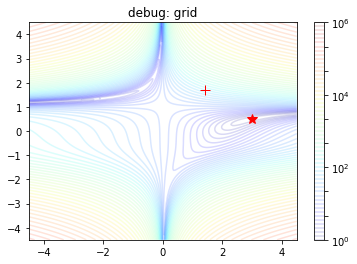

In [75]:
ax = plt.gca()
cm=ax.contour(x, y, z, levels=np.logspace(0, logzmax//2, 55), norm=LogNorm(), cmap=plt.cm.jet, alpha=0.15)
plt.colorbar(cm)
ax.plot(*minima_, 'r*', markersize=10)
ax.plot(*problem.x0, 'r+', markersize=10)
plt.title('debug: grid')

plt.show()

# Run

In [93]:
# you could use a lr scheduler too
scheduler = lambda optimizer: CyclicLR(optimizer, base_lr=1e-5, max_lr=5e-3, step_size=100, mode='exp_range', gamma=0.9983)

In [122]:
import torch.optim as optim
lr = problem.lr
constructors = dict(
    # Good high dimensional optimizers sometimes do poorly in low D spaces, so we will lower the LR on simple optimisers
    # need smaller lr's sometimes
    SGD= lambda params: optim.SGD(params, lr=lr/2),
    momentum = lambda params: optim.SGD(params, lr=lr/2, momentum=0.9, nesterov=False, dampening=0),
    momentum_dampen = lambda params: optim.SGD(params, lr=lr/2, momentum=0.9, nesterov=False, dampening=0.3),
    nesterov = lambda params: optim.SGD(params, lr=lr/2, momentum=0.9, nesterov=True, dampening=0),
    nesterov_decay = lambda params: optim.SGD(params, lr=lr/2, momentum=0.9, nesterov=True, weight_decay=1e-4, dampening=0),
    
    # need larger lr's sometimes
    Adadelta = lambda params: optim.Adadelta(params),
    Adagrad = lambda params: optim.Adagrad(params, lr=lr*20),
    
    # 
    Adamax = lambda params: optim.Adamax(params, lr=lr*20),
    RMSprop = lambda params: optim.RMSprop(params, lr=lr*10),
    Adam = lambda params: optim.Adam(params, lr=lr*10),
#     Adam_decay = lambda params:  optim.Adam(params, lr=lr*10, weight_decay=1e-9),
    
    # need to read about these, might not be comparable
#     ASGD = lambda params: optim.ASGD(params, lr=lr),
#     Rprop = lambda params: optim.Rprop(params, lr=lr),
#     LBFGS = lambda params: optim.LBFGS(params),
)

In [123]:
# maybe I want to print full names?
full_names = {}
for name, constructor in constructors.items():
    x0 = [1,2]
    params = Variable(torch.Tensor(x0), requires_grad=True)
    o = constructor([params])
    lr = o.param_groups[0]['lr']
    full_names[name]=f'{name} lr={lr:1.1e}'
    print(full_names[name])

SGD lr=1.0e-03
momentum lr=5.0e-04
momentum_dampen lr=2.5e-04
nesterov lr=1.3e-04
nesterov_decay lr=6.3e-05
Adadelta lr=1.0e+00
Adagrad lr=2.0e+01
Adamax lr=4.0e+02
RMSprop lr=4.0e+03
Adam lr=4.0e+04


In [127]:
results = {}
distance = {}

for name, constructor in tqdm(constructors.items()):
    data, dist, lrs = test_f(problem.f, problem.df, constructor, x0=problem.x0, steps=problem.steps, scheduler=scheduler)
    
    results[name] = data
    distance[name] = dist
len(results)

# calc paths and elevation
methods = constructors.keys()
paths = np.array([path.T for path in results.values()]) # should be (2,N) each
zpaths = np.array([[problem.f(torch.FloatTensor(p)).numpy()-z_min[0] + zeps for p in path.T] for path in paths])
paths.shape, zpaths.shape

# DEBUG: check z's
for i, name in enumerate(results):
    zmax = zpaths[i][np.isfinite(zpaths[i])].max()
    print(name, zmax, '\t', np.isfinite(zmax).all(), '\t', zmax.max()>z[:,0].max())
    
# clip zpaths
zmax = z.max()
zpaths[np.isfinite(zpaths)==False]=zmax
zpaths = np.clip(zpaths, 0, zmax)
zpaths.shape





SGD 96.1863 	 True 	 False
momentum 96.1863 	 True 	 False
momentum_dampen 96.1863 	 True 	 False
nesterov 1.30445e+09 	 True 	 True
nesterov_decay 2.08642e+08 	 True 	 True
Adadelta 96.8831 	 True 	 False
Adagrad 96.8797 	 True 	 False
Adamax 96.8797 	 True 	 False
RMSprop 96.8495 	 True 	 False
Adam 96.8797 	 True 	 False


(10, 1400, 1)

# Preview plots

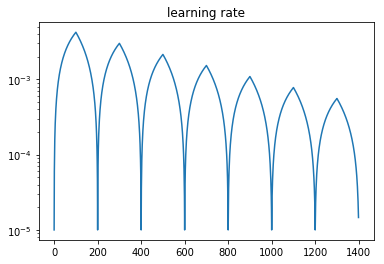

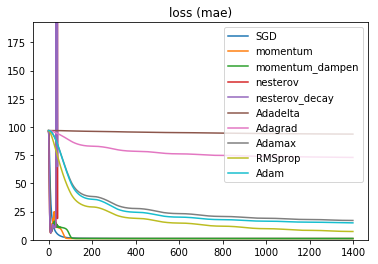

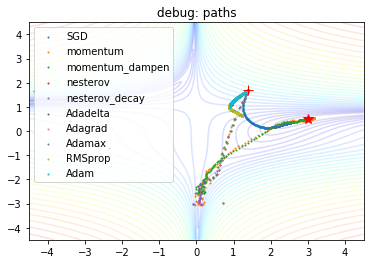

In [128]:
# Preview plots
# static preview 2d to let you debug your steps and learning rate
plt.plot(lrs)
plt.yscale('log')
plt.title('learning rate')
plt.show()

# loss
for i, name in enumerate(results):
    plt.plot(np.abs(zpaths[i]), label=name)
plt.legend()
plt.title('loss (mae)')
plt.ylim(0,zpaths[:,0].mean()*2)
plt.show()



# Position
ax = plt.gca()
for name in results:
    plt.scatter(*results[name].T, label=name, s=1)
plt.legend()
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

cm=ax.contour(x, y, z, levels=np.logspace(0, logzmax//2, 35), norm=LogNorm(), cmap=plt.cm.jet, alpha=0.15)
# plt.colorbar(cm)
ax.plot(*minima_, 'r*', markersize=10)
ax.plot(*problem.x0, 'r+', markersize=10)
plt.title('debug: paths')

plt.show()

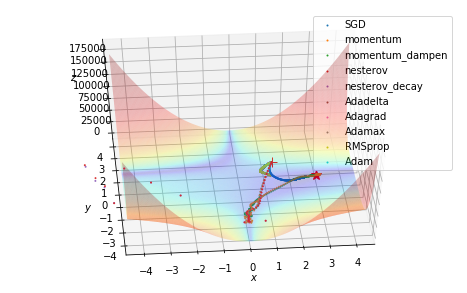

In [129]:
# static preview 3d
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=azim)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, edgecolor='none', alpha=.25, cmap=plt.cm.jet)
ax.plot(*minima_, problem.f(minima_).numpy(), 'r*', markersize=10)
ax.plot(*_x0, problem.f(_x0).numpy(), 'r+', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

# anim = TrajectoryAnimation3D(*paths, zpaths=zpaths, labels=methods, ax=ax)
# quick plot to let you debug your steps and learning rate
ax = plt.gca()
for i, name in enumerate(results):
    ax.scatter3D(*results[name].T, zpaths[i], label=name, s=1)
plt.legend()
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

ax.legend(loc='upper right')

# Animation

In [130]:
from matplotlib import rcParams
rcParams['figure.figsize']=(10,10)
rcParams['figure.dpi']=100
rcParams['animation.writer']='ffmpeg' # faster than fmmpeg
rcParams['savefig.dpi']=180
rcParams['animation.codec']='h264'

# rcParams['savefig.bbox'] = 'tight'
seconds = 20
fps = 30 # too low and you will miss the fast moving ones
rcParams['animation.bitrate']=-1 #fps*1000//25 # ~1mb/s
cuttoff=problem.steps//1 # if we want to crop the data to X steps, judging by the loss plot

decimation = int(np.round(cuttoff/(seconds*fps))) or 1 # don't need to plot every step
# assert cuttoff>seconds*fps
decimation, cuttoff,seconds*fps, problem.steps

('videos/beales_20171117_04-01-14', 2, 1400, 600, 1400)

In [150]:
if scheduler:
    params = Variable(torch.FloatTensor([0,1]), requires_grad=True)
    optimizer = optim.Adam([params])
    scheduler_name = type(scheduler(optimizer)).__name__
else:
    scheduler_name='None'

title=f'function: f{problem.f.__name__}'
if scheduler:
    title += f', scheduler={scheduler_name}'
title


'function: fbeales, scheduler=CyclicLR'

In [152]:
save_file = 'videos/{name:}_{scheduler}_{ts:}'.format(name=problem.f.__name__, ts=ts, scheduler=scheduler_name)
save_file

'videos/beales_CyclicLR_20171117_04-01-14'

In [153]:
# from http://louistiao.me/notes/visualizing-and-animating-optimization-algorithms-with-matplotlib/
class TrajectoryAnimation(animation.FuncAnimation):
    
    def __init__(self, *paths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths

        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(paths, labels)]
        self.points = [ax.plot([], [], 'o', color=line.get_color())[0] 
                       for line in self.lines]

        super(TrajectoryAnimation, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line, point in zip(self.lines, self.points):
            line.set_data([], [])
            point.set_data([], [])
        return self.lines + self.points

    def animate(self, i):
        for line, point, path in zip(self.lines, self.points, self.paths):
            line.set_data(*path[::,:i])
            point.set_data(*path[::,i-1:i])
        return self.lines + self.points

In [154]:
class TrajectoryAnimation3D(animation.FuncAnimation):
    
    def __init__(self, *paths, zpaths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths
        self.zpaths = zpaths
        
        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(paths, labels)]

        super(TrajectoryAnimation3D, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line in self.lines:
            line.set_data([], [])
            line.set_3d_properties([])
        return self.lines

    def animate(self, i):
        for line, path, zpath in zip(self.lines, self.paths, self.zpaths):
            line.set_data(*path[::,:i])
            line.set_3d_properties(zpath[:i])
        return self.lines

# 2d anim

hint on saving https://eli.thegreenplace.net/2016/drawing-animated-gifs-with-matplotlib/


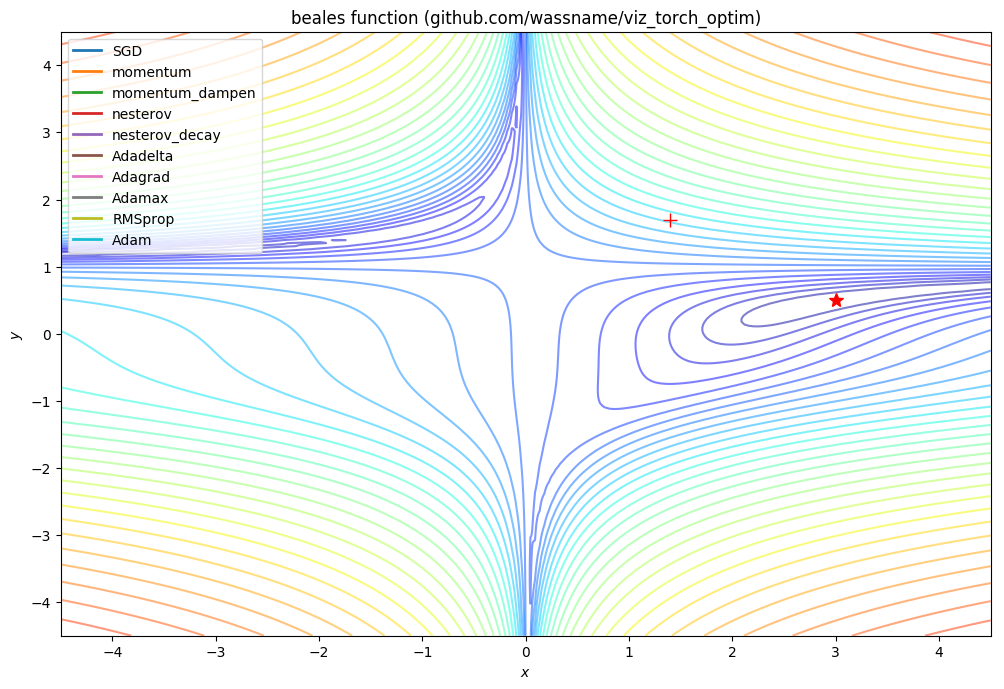

In [155]:
fig, ax = plt.subplots(figsize=(12, 8))
# fig.set_tight_layout(True)
ax.contour(x, y, z, levels=np.logspace(0, logzmax//2, 35), norm=LogNorm(), cmap=plt.cm.jet, alpha=0.5)
ax.plot(*minima_, 'r*', markersize=10)
ax.plot(*problem.x0, 'r+', markersize=10)

ax.set_title('{} function (github.com/wassname/viz_torch_optim)'.format(problem.f.__name__))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation(*paths[:,:,::decimation], labels=methods, ax=ax, interval=1000//fps)

ax.legend(loc='upper left')

In [156]:
# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

fig size: 100.0 DPI, size in inches [ 12.   8.]


In [157]:
import matplotlib.animation
import logging
_log = logging.getLogger(matplotlib.animation.__file__)
_log.setLevel(logging.DEBUG)

Saving, fps o 30, dpi 180 are ok, mp4 is faster than other formats

ffmpeg does poort quality gifs, use  writer="imagemagick", for videos mp4 is quick, webm is nice too


In [ ]:
anim.save(save_file+'_2d'+'.mp4', fps=fps, writer="ffmpeg", codec='h264')

In [ ]:
# anim.save(save_file+'2d'+'.gif', fps=fps, codec='gif', writer="imagemagick") # slow, makes a large gif file

# 3d anim

In [ ]:
fig = plt.figure(figsize=(12, 12) )
fig.set_tight_layout(True)
ax = plt.axes(projection='3d', elev=50, azim=azim)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, edgecolor='none', alpha=.5, cmap=plt.cm.jet)
ax.plot(*minima_, problem.f(minima_).numpy(), 'r*', markersize=10)
ax.plot(*_x0, problem.f(_x0).numpy(), 'r+', markersize=10)

ax.set_title('{} function'.format(problem.f.__name__))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation3D(*paths[:,:,:crop:decimation], zpaths=zpaths[:,:,0][:,:crop:decimation], labels=methods, ax=ax, interval=1000//fps)

ax.legend(loc='upper right')

In [ ]:
# anim.save(save_file+'3d'+'.gif', fps=fps, codec='gif', writer="imagemagick")
anim.save(save_file+'_3d'+'.mp4', fps=fps, writer="ffmpeg", codec='h264')

# loss anim

same as 2d but instead of x,y it's steps,np.abs(z-zmin)

In [ ]:
index = np.arange(1,problem.steps+1,1)[None,:]
index= np.array([index]*zpaths.shape[0])
loss_paths = np.concatenate([index, zpaths[:,None,:,0]], 1)
loss_paths.shape

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('$step$')
ax.set_ylabel('$loss$')
ax.set_title('{} function'.format(problem.f.__name__))

ax.set_xlim((0, loss_paths[:,0,:].max()))
ax.set_ylim((0, loss_paths[:,1,:].max()))

anim = TrajectoryAnimation(*loss_paths[:,:,:crop:decimation], labels=methods, ax=ax)

ax.legend(loc='upper right')

In [ ]:
# anim.save(save_file+'loss'+'.gif', fps=fps, codec='gif', writer="imagemagick")
anim.save(save_file+'_loss'+'.mp4', fps=fps, writer="ffmpeg", codec='h264')